In [1]:
import plotly.graph_objects as go
# import kaleido
from plotly.subplots import make_subplots
import plotly.io as pio
import pandas as pd
import numpy as np
import json

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

# local modules 
import sys
sys.path.insert(0, "../scripts")
import helpers as h
import seaborn as sns

import matplotlib.pyplot as plt

from numpy.linalg import lstsq
import scipy.signal

In [8]:
a00, a01 = h.import_desired_data("A", "15T")
# TODO edit in function 
a00.set_index(a00["DateTime"].values, inplace=True)
temp = a01["Temp C"]
time = a01["DateTime"]
amb = a01["Ambient Temp"]
a01.set_index(time.values, inplace=True)
print(a00["Window Open"].unique(), a01["Window Open"].unique(), a00.columns)



[1.] [0. 1.] Index(['DateTime', 'Temp C', 'RH %', 'Room', 'Ambient Temp', 'Ambient RH',
       'Window Open'],
      dtype='object')


## Testing Guesses

In [5]:
def make_fit(series, A, w, phi, w_t_var):
    n = len(series)
    t = np.arange(n)

    w_t = np.random.normal(0, 1, size=w_t_var)
    x_t = A*np.cos(2*np.pi*w*t + phi) # + w_t

    return x_t, t

In [6]:
def norm_grad(series):
    return h.normalize(np.gradient(series))

In [11]:
# normalized temperature 
norm_temp = h.normalize(temp)

# sinusoidal fit to normalized temp (eyeballing )
xt, t = make_fit(series=temp, A=-0.5, w=3.9*(1/(len(temp))), phi=0.8, w_t_var=1)
xt += 0.5

# difference and derivative 
dif_xt = norm_temp - xt 
ddt_dif_xt= norm_grad(dif_xt)

# ambient temp 
amb = h.normalize(a00["Ambient Temp"])



fig = go.Figure()

fig.add_trace(go.Scatter(
    x=time, y=a01["Window Open"], name="Window", mode='lines',
))


fig.add_trace(go.Scatter(x=time, y=ddt_dif_xt, name="ddt_dif_xt", mode='lines',))

fig.add_trace(go.Scatter( x=time, y=amb,  name="Ambient", mode='lines',))

# fig.add_trace(go.Scatter( x=time,y=ddt_amb, name="ddt_Ambient", mode='lines',))

# fig.add_trace(go.Scatter( x=time, y=ddt2_amb,name="ddt_Ambient",mode='lines',))

# fig.add_trace(go.Scatter( x=time_amb_sol, y=fit_amb, name="fit_amb", mode='lines', ))

# fig.add_trace(go.Scatter( x=time_amb_sol, y=ddt_fit_amb, name="ddt_fit_amb", mode='lines', ))



## Frequency analysis 
http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2015/tutorials/t7a_time_series.html

In [28]:
freqdf = a01.filter(["DateTime", "Temp C"], axis=1)
freqdf = freqdf.reset_index(drop=True)
freqdf["ddt_dif_xt"] = ddt_dif_xt

# sampling rate 
inter_sample_time = freqdf["DateTime"][1] - freqdf["DateTime"][0]
print('inter_sample_time =', inter_sample_time.total_seconds(), 's')

freqdf["Time"] = freqdf["DateTime"] - freqdf["DateTime"].min()
freqdf["Time"] = freqdf["Time"].dt.total_seconds()


freqdf

inter_sample_time = 900.0 s


,DateTime,Temp C,ddt_dif_xt,Time
0,2022-07-20 07:15:00,23.4386,0.165671,0.0
1,2022-07-20 07:30:00,23.4178,0.202032,900.0
2,2022-07-20 07:45:00,23.4154,0.561096,1800.0
3,2022-07-20 08:00:00,23.5538,0.814707,2700.0
4,2022-07-20 08:15:00,23.6650,0.783955,3600.0
...,...,...,...,...
380,2022-07-24 06:15:00,23.3738,0.502745,342000.0
381,2022-07-24 06:30:00,23.3722,0.488154,342900.0
382,2022-07-24 06:45:00,23.3578,0.471588,343800.0
383,2022-07-24 07:00:00,23.3578,0.499834,344700.0


In [29]:
inter_sample_time = freqdf["Time"][1] - freqdf["Time"][0]
print('inter_sample_time =', inter_sample_time, 's')

# # Check to make sure they are all the same
print('All the same?:', np.allclose(np.diff(freqdf["Time"]), inter_sample_time))

n_samples = len(freqdf)
sampling_freq = 1/inter_sample_time 

print(f"n_samples: {n_samples}, sampling_freq: {sampling_freq}")

inter_sample_time = 900.0 s
All the same?: True
n_samples: 385, sampling_freq: 0.0011111111111111111


In [30]:
# fig = go.Figure()

# fig.add_trace(go.Scatter(
#     x=freqdf["Time"],
#     y=freqdf["Temp C"], 
#     name="Window",
#     mode='lines',
# ))


In [39]:
np.fft.fft(freqdf["Temp C"].values)[0:10]

array([ 9.53964733e+03 +0.j        , -4.69390674e+01+10.5244864j ,
       -4.72158494e+01-15.22813809j, -1.67773619e+01-14.22839371j,
       -6.96550619e+01-86.55826389j, -1.50323445e+01-15.41665608j,
        8.74945882e-01-11.11375041j, -1.83100907e+01-13.56926099j,
       -4.42413033e+00 -1.63497008j,  1.75371713e+00 -2.14450275j])

In [40]:
np.abs(np.fft.fft(freqdf["Temp C"].values))[0:10]

array([9.53964733e+03, 4.81044786e+01, 4.96108115e+01, 2.19983422e+01,
       1.11104278e+02, 2.15324097e+01, 1.11481379e+01, 2.27900037e+01,
       4.71657252e+00, 2.77027360e+00])

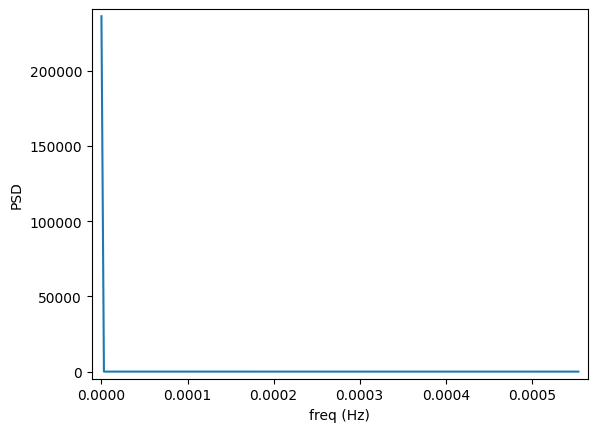

In [50]:
# # Determine frequencies
# f = np.fft.fftfreq(n_samples) * sampling_freq

# # Compute power spectral density
# psd_temp = np.abs(np.fft.fft(freqdf["Temp C"].values))**2 / n_samples

# psd_ddt = np.abs(np.fft.fft(freqdf["ddt_dif_xt"].values))**2 / n_samples


# # Make plot
# plt.plot(f[f>=0], psd_temp[f>=0])
# plt.xlabel('freq (Hz)')
# plt.ylabel('PSD')
# plt.margins(0.02)

In [58]:
f_ddt, psd_ddt = scipy.signal.periodogram(freqdf["ddt_dif_xt"], fs=sampling_freq)

f_temp, psd_temp = scipy.signal.periodogram(freqdf["Temp C"], fs=sampling_freq)


In [59]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=f_temp,
    y=psd_temp, 
    name="Temp",
    mode='lines',
))

# fig.update_yaxes(type="log")


fig.add_trace(go.Scatter(
    x=f_ddt,
    y=psd_ddt, 
    name="DDT",
    mode='lines',
))

In [48]:
fig = go.Figure()

# fig.add_trace(go.Scatter(
#     x=f[f>=0],
#     y=psd_temp[f>=0], 
#     name="Window",
#     mode='lines',
# ))

fig.add_trace(go.Scatter(
    x=f,
    y=psd_temp, 
    name="Temp",
    mode='lines',
))

fig.update_yaxes(type="log")


fig.add_trace(go.Scatter(
    x=f,
    y=psd_ddt, 
    name="DDT",
    mode='lines',
))

/Users/julietnwagwuume-ezeoke/_UILCode/windows/localwindowsenv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning:

nperseg = 1024 is greater than input length  = 385, using nperseg = 385



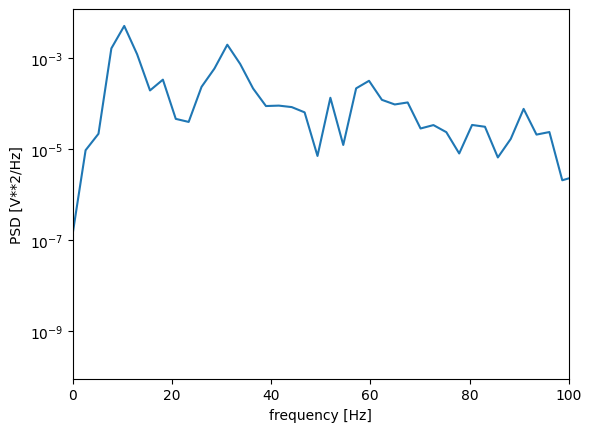

In [24]:
# f contains the frequency components
# S is the PSD
fs = 1000
signal = ddt_dif_xt
(f, S)= scipy.signal.welch(signal, fs, nperseg=1024)

plt.semilogy(f, S)
plt.xlim([0, 100])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

## Autocorrelation 

In [25]:
def acf1(x, nlags=None, acf_type="correlation", pacf=False, ax=None, **kwargs):
    lags = np.arange(1, nlags + 1)

    if pacf:
        if acf_type == "correlation":
            values = sm.tsa.pacf(x, nlags=nlags)[1:]
            ylabel = "PACF"
    else:
        if acf_type == "correlation":
            values = sm.tsa.acf(x, nlags=nlags, fft=False)[1:]
            ylabel = "ACF"
        elif acf_type == "covariance":
            values = sm.tsa.acovf(x, nlag=nlags)[1:]
            ylabel = "ACoV"

    if ax is None:
        ax = plt.gca()
 
    ax.bar(lags, values, **kwargs)
    ax.axhline(0, color="black", linewidth=1)
    if acf_type == "correlation":
        conf_level = 1.96 / np.sqrt(x.shape[0])
        ax.axhline(conf_level, color="red", linestyle="--", linewidth=1)
        ax.axhline(-conf_level, color="red", linestyle="--", linewidth=1)
    ax.set_xlabel("LAG")
    ax.set_ylabel(ylabel)

    return ax

<AxesSubplot:xlabel='LAG', ylabel='ACF'>

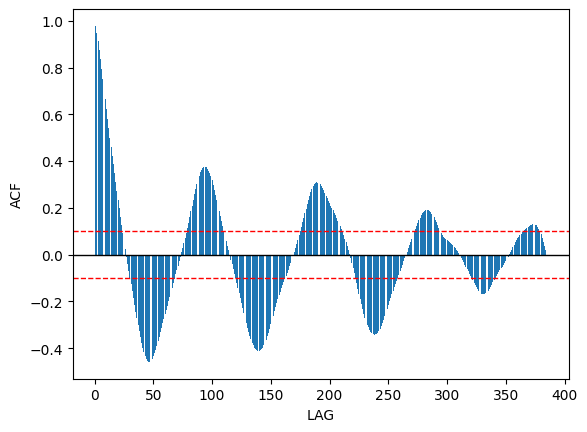

In [26]:
acf1(a01["Temp C"], nlags = (len(a01["Temp C"])-1))

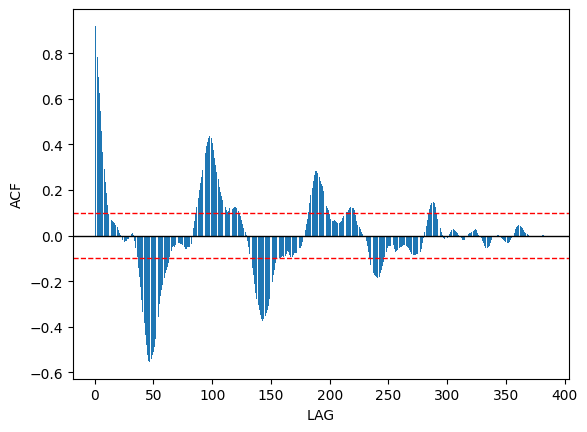

In [27]:
corr_array = acf1(pd.Series(ddt_dif_xt), nlags = (len(a01["Temp C"])-1))